In [2]:
import _utils.helper as hlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import join

def show_model_info(model_h):
    for i, v in model_h['hyper_parameters'].items():
        val = v
        if type(val) == str:
            if 'RMSprop' in v: val = 'RMSprop'
            elif 'adam' in v: val = 'adam'
        print(i+':', '\t',val)
    duration = model_h.get('train_duration')
    if duration != None: duration = round(duration/60, 1)
    #print(model_h['history'].model.get_config())
    print('train duration:\t', duration)
    model_h['history'].model.summary()

## load model

model file name is: 15804_9_9_0_15_Flatten_2dim_768_ready_to_visualization
<function xlabel at 0x0000019FD842FB88>


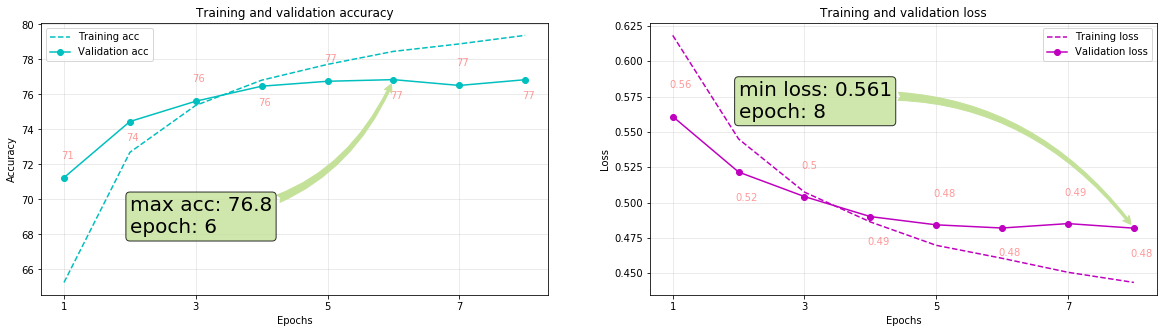

samples_count: 	 301849
samples_are_balanced: 	 True
train_split: 	 0.8
validation_split: 	 0.2
pretrained_vec: 	 None
max_words: 	 30000
maxlen: 	 600
embedding_dim: 	 2
epochs: 	 8
batch_size: 	 32
learning_rate: 	 0.0001
optimizer: 	 <keras.optimizers.Adam object at 0x000001D5364FBE08>
metrics: 	 ['acc']
train duration:	 4.8
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 2)            60000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               153728    
______________________________________________________

In [127]:
model_name = '15804_9_9_0_15_Flatten_2dim_768_ready_to_visualization' #'15805_5_2_6_41_Conv1D_LSTM_77.2'
models_path = './models/samples_300k'
model_h = hlp.load(join(models_path, model_name))
h_params = model_h['hyper_parameters']
model = model_h['history'].model
print('model file name is:', model_name)
hlp.show_model_plot(model_h, (.95,.02), (.95,1.1));
show_model_info(model_h)
print('-'.join(['' for i in range(0, 16)]))

## load data

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

data_reviews = hlp.load('./imported_data/all_genres_preprocessed_' + str(h_params['max_words']) + '_balanced' if h_params['samples_are_balanced'] else '')

df_reviews = data_reviews['df']
tokenizer = data_reviews['tokenizer']

# shuffle data
df_reviews = df_reviews.sample(frac=1, random_state=1)

# cutt data
df_reviews = df_reviews[:h_params['samples_count']]

paded_sequences = pad_sequences(df_reviews['sequence'].tolist(), maxlen=h_params['maxlen'])

train_len = int(df_reviews['sequence'].count()*h_params['train_split'])

x_test = paded_sequences[train_len:]
y_test = df_reviews['is_spoiler'].tolist()[train_len:]

len(x_test)

60370

## evaluate model

In [4]:
model.evaluate(x_test, y_test)

60370/60370 [==============================] - 49s 812us/step


[0.4521937764222128, 0.7819115519523621]

## visualization

In [134]:
invert_word_index = {v:i for i, v in tokenizer.word_index.items()}
#-------------------------------------------------------------------------------------------
def get_color_escape(r, g, b, background=False):
    return '\033[{};2;{};{};{}m'.format(48 if background else 38, r, g, b)
#-------------------------------------------------------------------------------------------
def colorize_text(input_text, rgb_text=(0, 0, 0), rgb_back=(128, 255, 255)):
    RESET = '\033[0m'
    return get_color_escape(rgb_text[0], rgb_text[1], rgb_text[2]) + get_color_escape(rgb_back[0], rgb_back[1], rgb_back[2], True)+ input_text + RESET
#-------------------------------------------------------------------------------------------
def clamp(input_value, up=10, down=0):
    if input_value > up: return up
    elif input_value < down: return down
    else: return input_value

def colorize_text_background_to_red_cyan(input_text, value):
    return colorize_text(input_text,
                        (0, 0, 0),
                        (clamp(int(1.5 * value + 100), 255, 0),
                        clamp(255 - 2 * value + 100, 255, 0),
                        clamp(255 - 2 * value + 100, 255, 0)))
#-------------------------------------------------------------------------------------------
def sequence_to_colorized_review_words(review_sequence, invert_word_index, model):
    from keras.backend import function
    get_embed_out = function([model.layers[0].input], [model.layers[0].output])
    layer_output = get_embed_out([review_sequence])

    review_words = [invert_word_index.get(i, '?') for i in review_sequence]
    words_dims = notmalize_words_vecs(layer_output[0])

    review_words_colorized = []
    for i, word in enumerate(review_words):
        review_words_colorized.append(colorize_text_background_to_red_cyan(word, word_vec_distance_2d(words_dims[i])))  
    return review_words_colorized
#-------------------------------------------------------------------------------------------
def notmalize_words_vecs(words_vecs):
    for vec in words_vecs:
        for i, v in enumerate(vec):
            d = [item[i] for item in words_vecs]
            vec[i] -= np.mean(d)
            vec[i] /= np.std(d)
    return words_vecs
#-------------------------------------------------------------------------------------------
def word_vec_distance_2d(word_vec):
    import math
    #if word_vec[1] >= -word_vec[0]: return 0
    if word_vec[1] <= -word_vec[0]: return 0
    from_word_vec = (word_vec[0], -word_vec[0])
    #from_word_vec = (0, 0)
    #from_word_vec = (1, 1)
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(from_word_vec, word_vec)]))
    return int(distance*255)
#-------------------------------------------------------------------------------------------
def print_colorized_review(review_seuence, label, model):
    print(' '.join(sequence_to_colorized_review_words(review_seuence, invert_word_index, model)))
    print('predict is spoiler:', round(model.predict([[review_seuence]])[0][0], 2), '\t\t', 'label:', label)
    print()

def show_review_words_plot(review_sequence, label, model, normilization = False):
    from keras.backend import function
    get_embed_out = function([model.layers[0].input], [model.layers[0].output])
    layer_output = get_embed_out([review_sequence])

    review_words = [invert_word_index.get(i, '?') for i in review_sequence]
    if normilization: words_dims = notmalize_words_vecs(layer_output[0])
    else: words_dims = layer_output[0]
    plt.figure(figsize=(10, 10), dpi=80)
    plt.scatter(words_dims[:,0], words_dims[:,1], color='#05dfd7')
    if normilization: plt.plot(np.arange(-21,16)/100, -np.arange(-21,16)/100, color='#ffe196')
    else: plt.plot(np.arange(-21,16)/100, -np.arange(-21,16)/100, color='#ffe196')
    
    for i, txt in enumerate(review_words):
        plt.annotate(txt, (words_dims[i,0], words_dims[i,1]))
    print('predict is spoiler:', round(model.predict([[review_sequence]])[0][0], 2), '\t\t', 'label:', label)

def review_sequence_to_words(review_seuence, invert_word_index):
    return [invert_word_index.get(i, '?') for i in review_seuence]

def print_raw_review(review_seuence, invert_word_index):
    rwords = [invert_word_index.get(i, '?') for i in review_seuence]
    print(' '.join(rwords))
    print()
#-------------------------------------------------------------------------------------------
print(colorize_text('moh', rgb_back=(222, 222, 222)))
print(colorize_text_background_to_red_cyan('this text is red!!', 0))

moh
this text is red!!


In [184]:
test_index = 677
print_raw_review(x_test[test_index], invert_word_index)

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? going into savages i had little if not any expectations however midway through the movie i started hoping that this movie will not pan out as i had predicted just like an average narcotic movie with an insipid ending i'll explain 1 if oliver stone was ever going to generate any compassion and affection from the audie

In [183]:
good_list = [6, 677, 4, 7, 13, 18, 19, 34, 38, 40, 48, 55, 60, 665, 671, 674]

test_index = 677

print_colorized_review(x_test[test_index], y_test[test_index], model)

255m? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? going into savages i had little if not any expectations however midway through the movie i started hoping that this movie will not pan out as i had predicted just like an average narcotic movie with an insipid ending i'll explain 1 if oliver stone was ever going to generate any compassion and affection from the audience about a controversial three way relationship he could have at least given us a reason to buy into why two guys who are cliché polar opposites will share a girl without any form of power 

In [123]:
test_index = 6
print_colorized_review(x_test[test_index], y_test[test_index], model)

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? when the totality of life on earth as we know it is threatened by a horrible contagion that turns people into crazed rabid killers in under 30 seconds brad pitt's character gets no more freaked out than if he were dealing with a paper jam in a photo the writing pacing and acting in this film are on the level of an 8th grade 

predict is spoiler: 0.84 		 label: 1


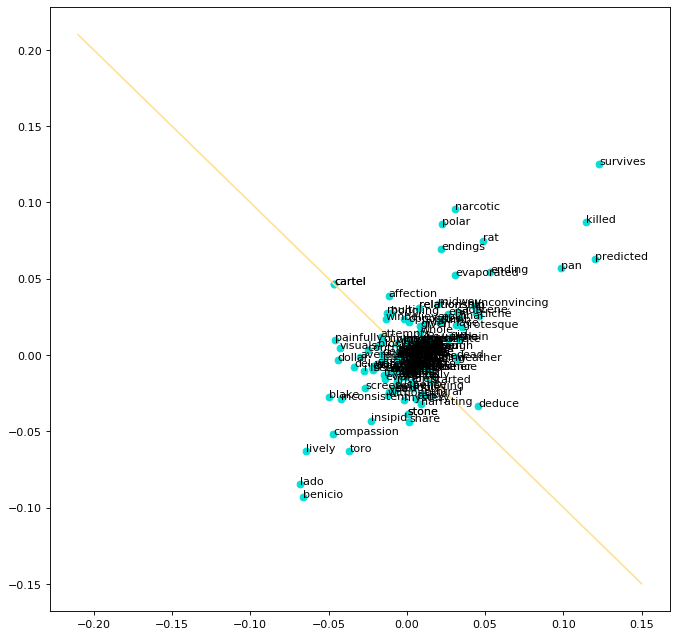

In [185]:
show_review_words_plot(x_test[test_index], y_test[test_index], model, False)

predict is spoiler: 0.86 		 label: 1


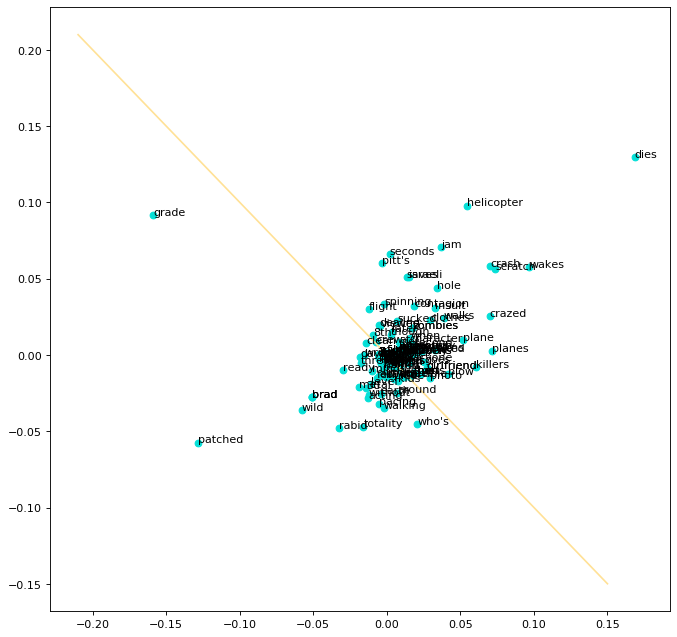

In [125]:
show_review_words_plot(x_test[test_index], y_test[test_index], model, False)


#### other-------------

In [26]:
def detectword(inword):
    if inword[1] > -inword[0]-.1: return 49
    else: return 41
import math
def distance(inword):
    # Example points in 3-dimensional space...
    x = (inword[0], -inword[0])
    y = (inword[0], inword[1])
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
    return int(distance*10000)

layer_output = get_embed_out([x_test[6]])
words = layer_output[0]
out0_colored = []
for i, text in enumerate(out0):
    out0_colored.append('\x1b[0;30;{}m'.format(detectword(words[i])) + text + '\x1b[0m')
print(' '.join(out0_colored)) 

NameError: name 'get_embed_out' is not defined

In [27]:
import keras
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

layer_output = get_embed_out([x_test[6]])
print(type(layer_output), len(layer_output), layer_output[0].shape)

words = layer_output[0]
    
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(words[:,0], words[:,1])

for i, txt in enumerate(out0):
    plt.annotate(txt, (words[i,0], words[i,1]))


layer_output = get_embed_out([x_test[4]])
print(type(layer_output), len(layer_output), layer_output[0].shape)

words = layer_output[0]
plt.scatter(words[:,0], words[:,1])
plt.plot(np.arange(-21,16)/100, -np.arange(-21,16)/100)

for i, txt in enumerate(out4):
    plt.annotate(txt, (words[i,0], words[i,1]))  

<class 'list'> 1 (600, 2)


NameError: name 'out0' is not defined

## save embedding

In [3]:
embedding_matrix = model.layers[0].get_weights()
hlp.save(embedding_matrix, join(models_path, model_name + '.embedding'))